# **Implementasi Prediksi Emisi Karbon Kota Purbalingga Menggunakan Machine Learning**

#### **Abstrak**

Proyek ini bertujuan untuk menganalisis dan memprediksi tingkat emisi karbon di tiga kecamatan terpilih di wilayah metropolitan *Purbalingga* (Pengadegan, Kaligondang, Bojongsari). Dengan memanfaatkan data geospasial publik dari OpenStreetMap (OSM) melalui pustaka OSMNx, kami mengekstrak fitur-fitur kunci perkotaan seperti kepadatan jalan, kepadatan bangunan, dan persentase ruang terbuka hijau. Fitur-fitur ini kemudian digunakan untuk membangun model klasifikasi machine learning dengan algoritma **Random Forest** dan **XGBoost**. Tujuan utamanya adalah untuk membandingkan kinerja kedua algoritma dalam mengklasifikasikan area berdasarkan potensi emisi karbonnya (Normal atau Tinggi) dan menyajikan hasilnya dalam bentuk visualisasi spasial yang informatif.

## **1. Pengumpulan dan Pra-pemrosesan Data**

Tahap awal ini mencakup semua langkah yang diperlukan untuk menyiapkan data, mulai dari mengimpor pustaka, mengonfigurasi lingkungan, mendefinisikan area studi, hingga mengambil dan membersihkan data dari OpenStreetMap.

### **1.1. Instalasi dan Impor Pustaka**

Sel pertama ini memastikan semua pustaka (*library*) yang dibutuhkan telah terinstal dan diimpor ke dalam lingkungan kerja.

In [117]:
!pip install --upgrade geopandas osmnx xgboost shapely matplotlib seaborn scikit-learn imbalanced-learn > /dev/null
print("[INFO] Pustaka yang diperlukan telah siap.")

import warnings
import pickle
import os
import time

import geopandas as gpd
import numpy as np
import pandas as pd

import osmnx as ox
from shapely.geometry import box

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
ox.settings.log_console = False
plt.style.use('ggplot')
sns.set_palette("Set2")
pd.set_option('display.precision', 2)

print("[INFO] Semua pustaka berhasil diimpor.")

[INFO] Pustaka yang diperlukan telah siap.
[INFO] Semua pustaka berhasil diimpor.


### **1.2. Konfigurasi Awal OSMNx**

Mengatur konfigurasi untuk OSMNx, termasuk penggunaan cache untuk mempercepat proses pengambilan data yang berulang dan mengatur timeout.

In [118]:
ox.settings.use_cache = True
ox.settings.overpass_endpoint = "https://overpass.kumi.systems/api/interpreter"
ox.settings.timeout = 300

### **1.3. Definisi Area Studi**

Mendefinisikan daftar kecamatan di wilayah Purbalingga yang akan menjadi fokus analisis.

In [119]:
KECAMATAN_TERPILIH = [
    "Pengadegan",
    "Kaligondang, Purbalingga, Central Java, Indonesia",
    "Bojongsari"
]
print(f"[INFO] Area studi telah ditentukan: {', '.join([k.split(',')[0] for k in KECAMATAN_TERPILIH])}")

[INFO] Area studi telah ditentukan: Pengadegan, Kaligondang, Bojongsari


### **1.4. Fungsi Utilitas**

Kumpulan fungsi yang dibuat untuk membantu proses pengolahan data, seperti membuat grid dan membersihkan data geospasial.

In [120]:
def buat_grid(batas: gpd.GeoDataFrame, ukuran_grid: int = 200) -> gpd.GeoDataFrame:
    """
    Membuat grid poligon seragam di dalam area batas administratif yang diberikan.

    Args:
        batas (gpd.GeoDataFrame): GeoDataFrame yang berisi poligon batas wilayah.
        ukuran_grid (int): Ukuran sisi setiap sel grid dalam meter.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame berisi grid yang telah dipotong sesuai batas wilayah.
    """
    batas_proj = batas.to_crs(epsg=3857)
    minx, miny, maxx, maxy = batas_proj.total_bounds

    sel_grid = [
        box(x0, y0, x0 + ukuran_grid, y0 + ukuran_grid)
        for x0 in np.arange(minx, maxx, ukuran_grid)
        for y0 in np.arange(miny, maxy, ukuran_grid)
    ]

    grid = gpd.GeoDataFrame({'geometry': sel_grid}, crs=batas_proj.crs)

    return gpd.overlay(grid, batas_proj, how='intersection').to_crs(batas.crs)

def bersihkan_fitur_dalam_batas(gdf: gpd.GeoDataFrame, batas: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Memotong fitur geografis (misal: jalan, bangunan) agar sesuai dengan batas wilayah.

    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame berisi fitur geografis.
        batas (gpd.GeoDataFrame): GeoDataFrame yang berisi poligon batas wilayah.

    Returns:
        gpd.GeoDataFrame: Fitur yang sudah dipotong dan dibersihkan.
    """
    mask = batas.geometry.unary_union

    return gdf.clip(mask).explode(ignore_index=True)

def dapatkan_data_osm(kecamatan: str) -> tuple:
    """
    Mengambil data jalan, bangunan, dan area hijau dari OSM.
    Menyimpan hasil ke dalam cache (file pickle) untuk penggunaan selanjutnya.

    Args:
        kecamatan (str): Nama kecamatan lengkap dengan wilayah administrasinya.

    Returns:
        tuple: Berisi (batas, jalan, bangunan, area_hijau).
    """
    folder_cache = "cached_osm"
    nama_file = kecamatan.split(",")[0].replace(" ", "_").lower()
    path_file = os.path.join(folder_cache, f"{nama_file}_osm.pkl")

    if os.path.exists(path_file):
        with open(path_file, "rb") as f:
            print(f"[INFO] Menggunakan data cache untuk {kecamatan.split(',')[0]}")
            return pickle.load(f)

    print(f"[PROSES] Mengambil data OSM baru untuk: {kecamatan.split(',')[0]}")
    try:
        batas = ox.geocode_to_gdf(kecamatan)

        jalan = ox.graph_to_gdfs(ox.graph_from_polygon(batas.geometry.iloc[0], network_type='drive'), nodes=False, edges=True)
        bangunan = ox.features_from_place(kecamatan, tags={'building': True})
        tag_hijau = {
            'leisure': ['park', 'garden'],
            'landuse': ['grass', 'forest', 'farmland', 'meadow', 'orchard'],
            'natural': ['wood', 'scrub', 'wetland']
        }
        area_hijau = ox.features_from_polygon(batas.geometry.iloc[0], tags=tag_hijau)

        jalan_bersih = bersihkan_fitur_dalam_batas(jalan, batas)
        bangunan_bersih = bersihkan_fitur_dalam_batas(bangunan, batas)
        hijau_bersih = bersihkan_fitur_dalam_batas(area_hijau, batas)

        os.makedirs(folder_cache, exist_ok=True)
        with open(path_file, "wb") as f:
           pickle.dump((batas, jalan_bersih, bangunan_bersih, hijau_bersih), f)

        return batas, jalan_bersih, bangunan_bersih, hijau_bersih
    except Exception as e:
        print(f"[ERROR] Gagal mengambil data untuk {kecamatan}: {e}")
        return None, None, None, None

def ekstrak_fitur_per_grid(grid: gpd.GeoDataFrame, jalan: gpd.GeoDataFrame, bangunan: gpd.GeoDataFrame, hijau: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Mengekstrak fitur-fitur relevan untuk setiap sel dalam grid.

    Args:
        grid (gpd.GeoDataFrame): Grid wilayah.
        jalan (gpd.GeoDataFrame): Data jalan.
        bangunan (gpd.GeoDataFrame): Data bangunan.
        hijau (gpd.GeoDataFrame): Data area hijau.

    Returns:
        gpd.GeoDataFrame: DataFrame dengan fitur-fitur yang telah diekstrak.
    """
    grid_proj = grid.to_crs(epsg=3857)
    jalan_proj = jalan.to_crs(epsg=3857)
    bangunan_proj = bangunan.to_crs(epsg=3857)
    hijau_proj = hijau.to_crs(epsg=3857)

    fitur_list = []
    for idx, sel in grid_proj.iterrows():
        geometri_sel = sel.geometry
        luas_km2 = geometri_sel.area / 1e6
        if luas_km2 == 0: continue

        panjang_jalan_km = jalan_proj[jalan_proj.intersects(geometri_sel)].geometry.length.sum() / 1000
        jumlah_bangunan = len(bangunan_proj[bangunan_proj.intersects(geometri_sel)])
        luas_hijau_km2 = hijau_proj[hijau_proj.intersects(geometri_sel)].geometry.area.sum() / 1e6

        fitur_list.append({
            'grid_id': idx,
            'luas_km2': luas_km2,
            'panjang_jalan_km': panjang_jalan_km,
            'jumlah_bangunan': jumlah_bangunan,
            'hijau_km2': luas_hijau_km2,
            'kepadatan_jalan': panjang_jalan_km / luas_km2 if luas_km2 > 0 else 0,
            'kepadatan_bangunan': jumlah_bangunan / luas_km2 if luas_km2 > 0 else 0,
            'persentase_hijau': (luas_hijau_km2 / luas_km2) * 100 if luas_km2 > 0 else 0,
            'geometry': geometri_sel
        })

    return gpd.GeoDataFrame(fitur_list, crs=grid_proj.crs).to_crs(epsg=4326)
print("[INFO] Semua fungsi utilitas telah didefinisikan.")

[INFO] Semua fungsi utilitas telah didefinisikan.


### **1.5. Proses Ekstraksi Data dan Fitur**

Langkah ini menjalankan *loop* utama untuk setiap kecamatan. Prosesnya meliputi pengambilan data dari OSM, pembuatan *grid*, visualisasi *overlay*, dan ekstraksi fitur.


[PROSES] Memproses kecamatan: Pengadegan
[INFO] Menggunakan data cache untuk Pengadegan


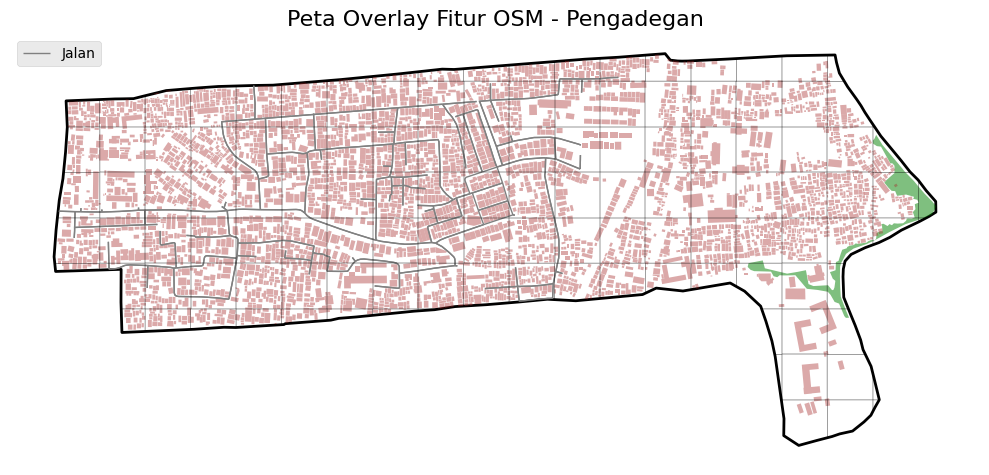

[SUKSES] 128 grid berhasil diproses untuk Pengadegan

[PROSES] Memproses kecamatan: Kaligondang
[INFO] Menggunakan data cache untuk Kaligondang


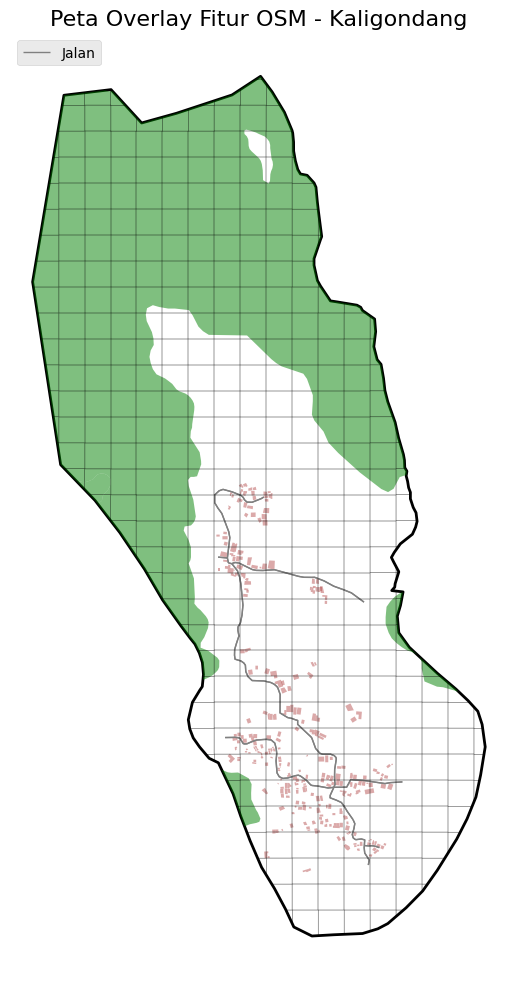

[SUKSES] 379 grid berhasil diproses untuk Kaligondang

[PROSES] Memproses kecamatan: Bojongsari
[INFO] Menggunakan data cache untuk Bojongsari


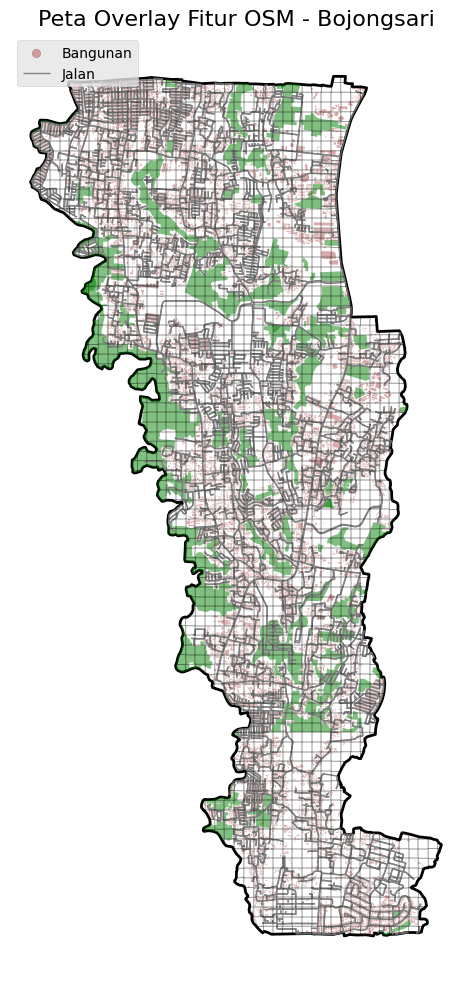

[SUKSES] 2154 grid berhasil diproses untuk Bojongsari

--------------------------------------------------
[INFO] Pra-pemrosesan data selesai.
Total grid yang dihasilkan: 2661
Distribusi grid per kecamatan:
kecamatan
Bojongsari     2154
Kaligondang     379
Pengadegan      128
Name: count, dtype: int64
--------------------------------------------------


In [121]:
semua_grid = []
for kec in KECAMATAN_TERPILIH:
    try:
        nama_kecamatan = kec.split(',')[0]
        print(f"\n[PROSES] Memproses kecamatan: {nama_kecamatan}")

        batas, jalan, bangunan, hijau = dapatkan_data_osm(kec)
        if batas is None: continue

        grid = buat_grid(batas, ukuran_grid=100)

        fig, ax = plt.subplots(figsize=(10, 10))
        batas.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='Batas Kecamatan')
        hijau.plot(ax=ax, color="green", alpha=0.5, label="Area Hijau")
        bangunan.plot(ax=ax, color="brown", alpha=0.4, label="Bangunan")
        jalan.plot(ax=ax, color="gray", linewidth=1, label="Jalan")
        grid.boundary.plot(ax=ax, color="black", linewidth=0.3, alpha=0.5)
        ax.set_title(f"Peta Overlay Fitur OSM - {nama_kecamatan}", fontsize=16)
        ax.legend(loc='upper left')
        plt.axis("off")
        plt.tight_layout()
        plt.show()

        df_grid = ekstrak_fitur_per_grid(grid, jalan, bangunan, hijau)
        df_grid['kecamatan'] = nama_kecamatan
        semua_grid.append(df_grid)
        print(f"[SUKSES] {len(df_grid)} grid berhasil diproses untuk {nama_kecamatan}")
    except Exception as e:
        print(f"[ERROR] Gagal memproses {kec.split(',')[0]}: {str(e)}")


df_semua_grid = pd.concat(semua_grid, ignore_index=True)

df_semua_grid.dropna(
    subset=['kepadatan_jalan', 'kepadatan_bangunan', 'persentase_hijau'],
    inplace=True
)

print("\n" + "-"*50)
print("[INFO] Pra-pemrosesan data selesai.")
print(f"Total grid yang dihasilkan: {len(df_semua_grid)}")
print("Distribusi grid per kecamatan:")
print(df_semua_grid['kecamatan'].value_counts())
print("-"*50)

## **2. Analisis Data Eksploratif (EDA)**

Sebelum membangun model, kita perlu memahami karakteristik dan distribusi dari data yang telah kita kumpulkan.

### **2.1. Statistik Deskriptif**

Melihat ringkasan statistik dari fitur-fitur numerik utama.

In [122]:
print("Statistik Deskriptif Fitur Utama:")
display(df_semua_grid[['kepadatan_jalan', 'kepadatan_bangunan', 'persentase_hijau']].describe())

Statistik Deskriptif Fitur Utama:


,kepadatan_jalan,kepadatan_bangunan,persentase_hijau
count,2661.00,2661.00,2.66e+03
mean,61.91,1610.57,2.23e+06
std,121.25,2531.28,1.14e+08
min,0.00,0.00,0.00e+00
25%,0.00,0.00,0.00e+00
50%,51.81,800.00,0.00e+00
75%,96.09,2500.00,7.01e+02
max,5055.32,85922.71,5.87e+09


### **2.2. Visualisasi Distribusi Fitur**

Menggunakan *boxplot* dan *histogram* untuk melihat sebaran data dan mengidentifikasi adanya outlier.

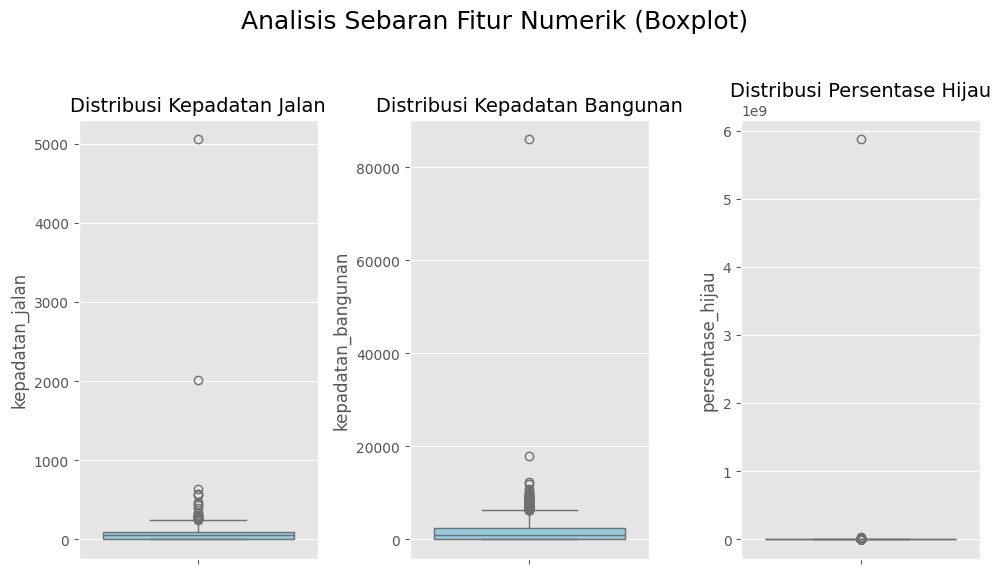

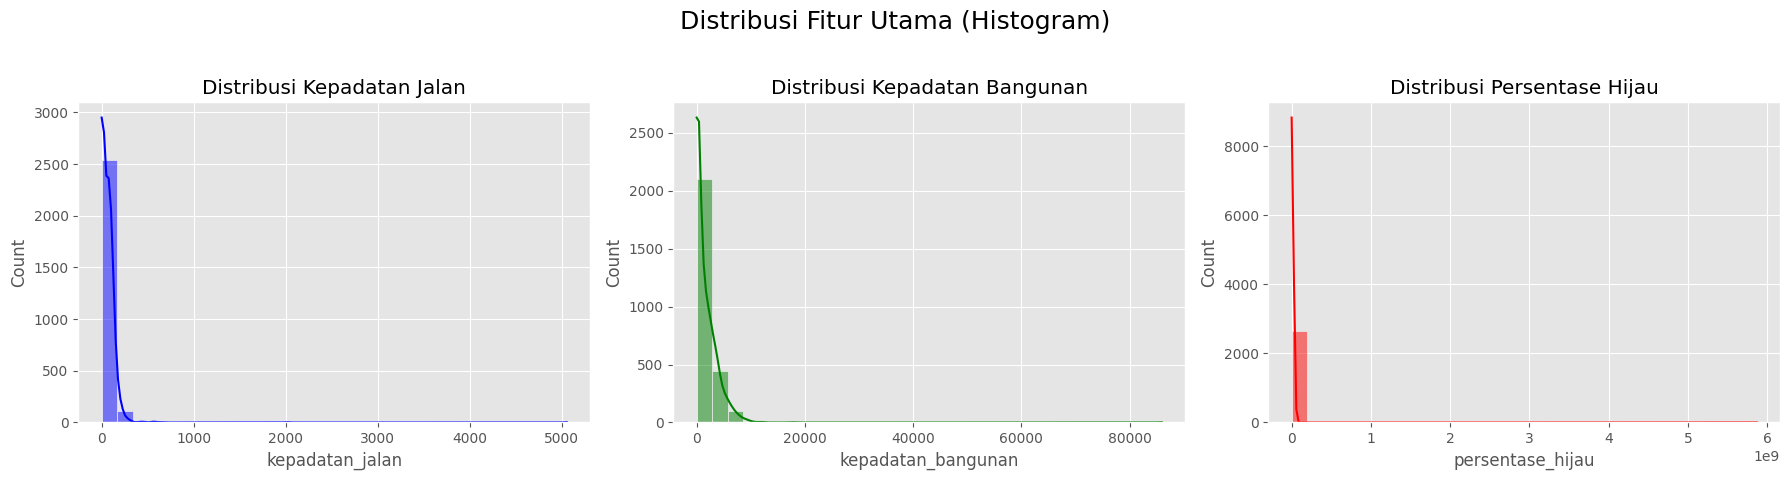

In [123]:
fitur_numerik = ["kepadatan_jalan", "kepadatan_bangunan", "persentase_hijau"]

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
for i, fitur in enumerate(fitur_numerik):
    sns.boxplot(y=fitur, data=df_semua_grid, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribusi {fitur.replace("_", " ").title()}', fontsize=14)
plt.suptitle("Analisis Sebaran Fitur Numerik (Boxplot)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df_semua_grid['kepadatan_jalan'], kde=True, ax=axes[0], color='blue', bins=30)
axes[0].set_title('Distribusi Kepadatan Jalan')
sns.histplot(df_semua_grid['kepadatan_bangunan'], kde=True, ax=axes[1], color='green', bins=30)
axes[1].set_title('Distribusi Kepadatan Bangunan')
sns.histplot(df_semua_grid['persentase_hijau'], kde=True, ax=axes[2], color='red', bins=30)
axes[2].set_title('Distribusi Persentase Hijau')
plt.suptitle("Distribusi Fitur Utama (Histogram)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **3. Pembuatan Label Emisi**

Karena dataset ini tidak memiliki label asli, kita perlu membuat label target (*ground truth*) berdasarkan kriteria yang telah ditentukan. Kriteria ini mengkategorikan setiap *grid* ke dalam tingkat emisi tertentu berdasarkan fitur-fiturnya.

### **3.1. Kriteria dan Formula Pelabelan**

Label emisi dibuat berdasarkan kriteria yang menggabungkan tiga fitur utama. Kriteria ini disederhanakan menjadi dua kelas: **Normal** dan **Tinggi**.

| Kategori Emisi Karbon | Persentase Area Hijau | Kepadatan Jalan (km/km²) | Kepadatan Bangunan (bangunan/km²) | Keterangan                                                                |
|-----------------------|------------------------|----------------------------|------------------------------------|---------------------------------------------------------------------------|
| Normal (Rendah)       | ≥ 30%                  | ≤ 5                        | ≤ 1000                              | Kota berkelanjutan, banyak RTH, lalu lintas rendah                        |
| Parah (Tinggi)        | < 15%                  | > 10                       | > 3000                              | Urban sprawl, minim RTH, lalu lintas dan kepadatan bangunan sangat tinggi |

Meskipun tidak digunakan secara langsung untuk pelabelan akhir, skor emisi dapat dihitung dengan formula berikut untuk analisis tambahan:

$$
\text{Skor Emisi} = (\alpha \cdot \text{Kepadatan Jalan}) + (\beta \cdot \text{Kepadatan Bangunan}) - (\gamma \cdot \text{Persentase Hijau})
$$

_di mana:_

- $\alpha$, $\beta$, $\gamma$ adalah bobot untuk setiap fitur.

### **3.2. Implementasi Pelabelan**

Menerapkan fungsi untuk memberi label pada setiap baris data. Awalnya, label dibagi menjadi tiga ("Normal", "Sedang", "Parah"), kemudian disederhanakan menjadi dua kelas ("Normal", "Tinggi") untuk membuat masalah klasifikasi biner yang lebih jelas.

Contoh data setelah pelabelan:


,kecamatan,kepadatan_jalan,kepadatan_bangunan,persentase_hijau,label_emisi
0,Pengadegan,0.00,6383.49,0.0,Tinggi
1,Pengadegan,43.83,4429.53,0.0,Tinggi
2,Pengadegan,31.81,3359.08,0.0,Tinggi
3,Pengadegan,0.00,4951.17,0.0,Tinggi
4,Pengadegan,0.00,7286.86,0.0,Tinggi


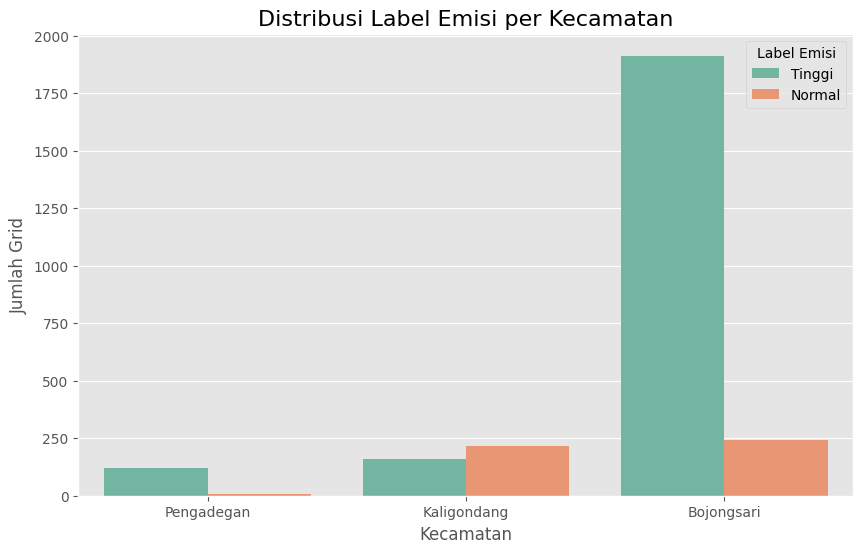

In [124]:
def label_emisi(row):
    """Memberi label emisi berdasarkan kriteria yang ditentukan."""
    if row['persentase_hijau'] >= 30 and row['kepadatan_jalan'] <= 5 and row['kepadatan_bangunan'] <= 1000:
        return 'Normal'
    elif 15 <= row['persentase_hijau'] < 30 and 5 < row['kepadatan_jalan'] <= 10 and 1000 < row['kepadatan_bangunan'] <= 3000:
        print(f"Row with index {row.name} is labeled as 'Sedang'. Features: Jalan={row['kepadatan_jalan']:.2f}, Bangunan={row['kepadatan_bangunan']:.2f}, Hijau={row['persentase_hijau']:.2f}")
        return 'Sedang'
    else:
        return 'Parah'

df_semua_grid["label_emisi_awal"] = df_semua_grid.apply(label_emisi, axis=1)

df_semua_grid["label_emisi"] = df_semua_grid["label_emisi_awal"].replace({
    'Sedang': 'Tinggi',
    'Parah': 'Tinggi'
})

print("Contoh data setelah pelabelan:")
display(df_semua_grid[['kecamatan', 'kepadatan_jalan', 'kepadatan_bangunan', 'persentase_hijau', 'label_emisi']].head())

plt.figure(figsize=(10, 6))
sns.countplot(data=df_semua_grid, x="kecamatan", hue="label_emisi", palette="Set2")
plt.title("Distribusi Label Emisi per Kecamatan", fontsize=16)
plt.xlabel("Kecamatan", fontsize=12)
plt.ylabel("Jumlah Grid", fontsize=12)
plt.legend(title='Label Emisi')
plt.show()

## **4. Pembangunan Model Machine Learning**

Tahap ini adalah inti dari proyek, di mana kita membangun dan melatih model *machine learning* untuk memprediksi label emisi.

### **4.1. Persiapan Data untuk Model**

Memisahkan fitur (X) dan target (y), serta melakukan *encoding* pada variabel target dari teks menjadi numerik.

In [125]:
FITUR = ['kepadatan_jalan', 'kepadatan_bangunan', 'persentase_hijau']
X = df_semua_grid[FITUR]
y = df_semua_grid['label_emisi']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Fitur yang digunakan (X):")
print(X.head())
print("\nLabel target yang di-encode (y):")
print(y_encoded[:5])
print(f"Kelas: {encoder.classes_}")

Fitur yang digunakan (X):
   kepadatan_jalan  kepadatan_bangunan  persentase_hijau
0             0.00             6383.49               0.0
1            43.83             4429.53               0.0
2            31.81             3359.08               0.0
3             0.00             4951.17               0.0
4             0.00             7286.86               0.0

Label target yang di-encode (y):
[1 1 1 1 1]
Kelas: ['Normal' 'Tinggi']


### **4.2. Penyeimbangan Kelas (Class Balancing)**

Distribusi kelas target seringkali tidak seimbang. Model yang dilatih pada data tidak seimbang cenderung bias terhadap kelas mayoritas. Oleh karena itu, kita perlu menyeimbangkan data.

#### **Alasan Pemilihan Teknik:**

* **Undersampling** dipilih karena implementasinya cepat dan efektif untuk dataset yang tidak terlalu besar. Teknik ini mengurangi jumlah sampel dari kelas mayoritas agar seimbang dengan kelas minoritas.
* **Alternatif:** SMOTE (*Synthetic Minority Over-sampling Technique*) adalah opsi lain yang populer, yaitu dengan membuat sampel sintetis untuk kelas minoritas. Kode untuk SMOTE juga disertakan sebagai komentar.



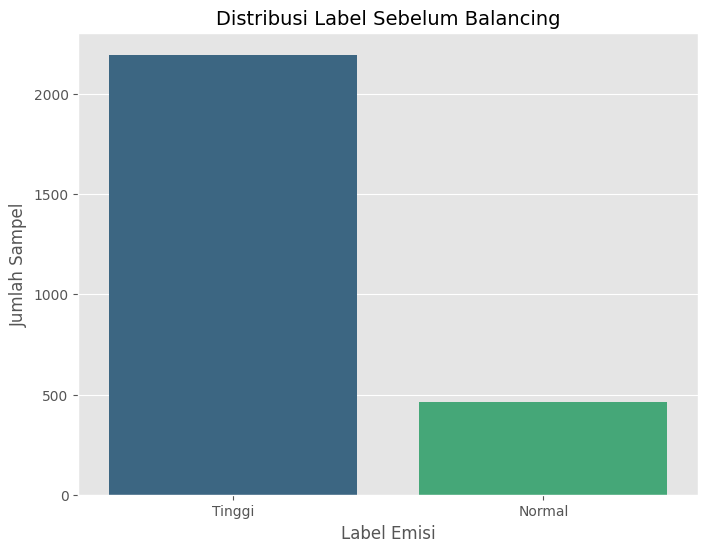


Distribusi label sebelum balancing:
label_emisi
Tinggi    2196
Normal     465
Name: count, dtype: int64


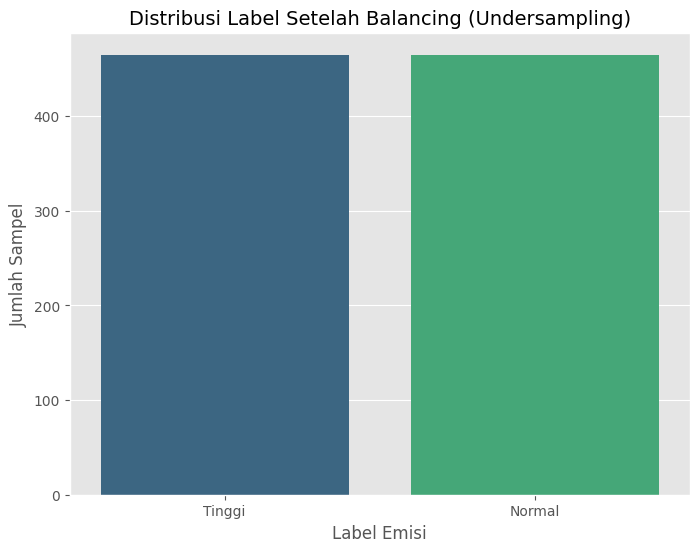


Distribusi label setelah balancing:
label_emisi
Tinggi    465
Normal    465
Name: count, dtype: int64


In [126]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette='viridis')
plt.title("Distribusi Label Sebelum Balancing", fontsize=14)
plt.xlabel("Label Emisi")
plt.ylabel("Jumlah Sampel")
plt.show()
print("\nDistribusi label sebelum balancing:")
print(y.value_counts())

df_balanced = pd.concat([X, y], axis=1)
kelas_mayoritas = df_balanced[df_balanced['label_emisi'] == 'Tinggi']
kelas_minoritas = df_balanced[df_balanced['label_emisi'] == 'Normal']

mayoritas_undersampled = resample(
    kelas_mayoritas,
    replace=False,
    n_samples=len(kelas_minoritas),
    random_state=42
)

df_undersampled = pd.concat([mayoritas_undersampled, kelas_minoritas])
X_balanced = df_undersampled[FITUR]
y_balanced_labels = df_undersampled['label_emisi']
y_balanced = encoder.transform(y_balanced_labels)

plt.figure(figsize=(8, 6))
sns.countplot(x=y_balanced_labels, palette='viridis')
plt.title("Distribusi Label Setelah Balancing (Undersampling)", fontsize=14)
plt.xlabel("Label Emisi")
plt.ylabel("Jumlah Sampel")
plt.show()
print("\nDistribusi label setelah balancing:")
print(y_balanced_labels.value_counts())

### **4.3. Pemisahan Data dan Pelatihan Model**

Membagi data yang sudah seimbang menjadi data latih (*train*) dan data uji (*test*), kemudian melatih kedua model.

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print(f"Ukuran data latih: {X_train.shape[0]} sampel")
print(f"Ukuran data uji: {X_test.shape[0]} sampel")

model_rf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

print("\n[PROSES] Melatih model dan menguji kompleksitas waktu...")

start_time_rf = time.time()
model_rf.fit(X_train, y_train)
rf_time = time.time() - start_time_rf

start_time_xgb = time.time()
model_xgb.fit(X_train, y_train)
xgb_time = time.time() - start_time_xgb

print(f"- Waktu pelatihan Random Forest: {rf_time:.4f} detik")
print(f"- Waktu pelatihan XGBoost: {xgb_time:.4f} detik")

Ukuran data latih: 651 sampel
Ukuran data uji: 279 sampel

[PROSES] Melatih model dan menguji kompleksitas waktu...
- Waktu pelatihan Random Forest: 1.3612 detik
- Waktu pelatihan XGBoost: 1.1122 detik


## **5. Evaluasi Kinerja Model**

Setelah model dilatih, kinerjanya harus diukur secara objektif menggunakan data uji yang belum pernah dilihat sebelumnya.


------ [ Hasil Evaluasi: Random Forest ] -----
Laporan Klasifikasi:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       140
      Tinggi       1.00      1.00      1.00       139

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



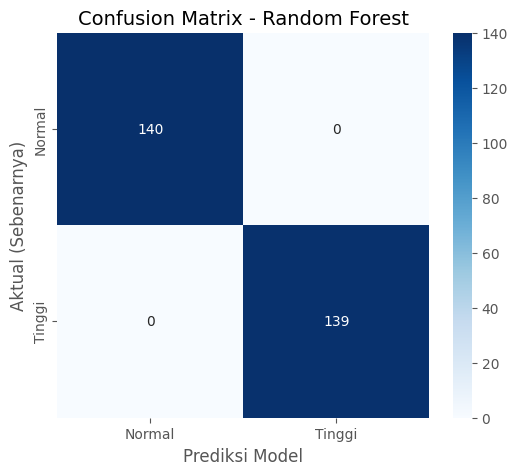

Skor ROC-AUC: 1.0000

------ [ Hasil Evaluasi: XGBoost ] -----
Laporan Klasifikasi:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       140
      Tinggi       1.00      1.00      1.00       139

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



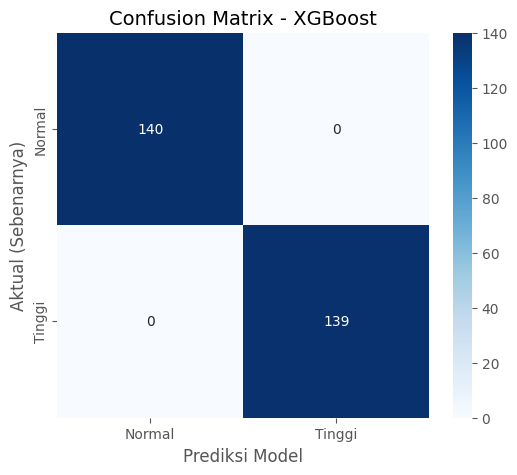

Skor ROC-AUC: 1.0000


In [128]:
def evaluasi_model(model, nama_model, X_test, y_test, encoder):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n------ [ Hasil Evaluasi: {nama_model} ] -----")

    print("Laporan Klasifikasi:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.title(f'Confusion Matrix - {nama_model}', fontsize=14)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Aktual (Sebenarnya)')
    plt.show()

    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"Skor ROC-AUC: {roc_auc:.4f}")
    return roc_auc

roc_rf = evaluasi_model(model_rf, "Random Forest", X_test, y_test, encoder)
roc_xgb = evaluasi_model(model_xgb, "XGBoost", X_test, y_test, encoder)

### **5.1. Perbandingan Kinerja Model**

Merangkum metrik-metrik utama dari kedua model dalam sebuah tabel untuk perbandingan yang lebih mudah.

In [129]:
report_rf = classification_report(y_test, model_rf.predict(X_test), target_names=encoder.classes_, output_dict=True)
report_xgb = classification_report(y_test, model_xgb.predict(X_test), target_names=encoder.classes_, output_dict=True)

perbandingan_data = {
    'Metrik': ['Akurasi', 'Presisi (Tinggi)', 'Recall (Tinggi)', 'F1-Score (Tinggi)', 'ROC-AUC'],
    'Random Forest': [
        report_rf['accuracy'],
        report_rf['Tinggi']['precision'],
        report_rf['Tinggi']['recall'],
        report_rf['Tinggi']['f1-score'],
        roc_rf
    ],
    'XGBoost': [
        report_xgb['accuracy'],
        report_xgb['Tinggi']['precision'],
        report_xgb['Tinggi']['recall'],
        report_xgb['Tinggi']['f1-score'],
        roc_xgb
    ]
}
df_perbandingan = pd.DataFrame(perbandingan_data)

print("Tabel Perbandingan Kinerja Model:")
display(df_perbandingan.round(3).style.set_caption("Perbandingan Metrik Kinerja Model"))

print("\nKesimpulan Perbandingan:")
if roc_xgb > roc_rf:
    print(f"- XGBoost lebih unggul dalam ROC-AUC (selisih: +{roc_xgb - roc_rf:.3f}), menunjukkan kemampuan generalisasi yang sedikit lebih baik.")
else:
    print(f"- Random Forest lebih unggul dalam ROC-AUC (selisih: +{roc_rf - roc_xgb:.3f}), menunjukkan kemampuan generalisasi yang sedikit lebih baik.")

Tabel Perbandingan Kinerja Model:


,Metrik,Random Forest,XGBoost
0,Akurasi,1.000000,1.000000
1,Presisi (Tinggi),1.000000,1.000000
2,Recall (Tinggi),1.000000,1.000000
3,F1-Score (Tinggi),1.000000,1.000000
4,ROC-AUC,1.000000,1.000000



Kesimpulan Perbandingan:
- Random Forest lebih unggul dalam ROC-AUC (selisih: +0.000), menunjukkan kemampuan generalisasi yang sedikit lebih baik.


## **6. Visualisasi dan Interpretasi Hasil**

Model terbaik (berdasarkan evaluasi) digunakan untuk memprediksi label emisi di seluruh area studi. Hasilnya kemudian divisualisasikan dalam bentuk peta spasial.

### **6.1. Visualisasi Spasial Hasil Prediksi**

Membuat peta yang mewarnai setiap *grid* berdasarkan prediksi tingkat emisinya. Kita akan menggunakan model **XGBoost** karena umumnya memiliki kinerja yang sedikit lebih baik.

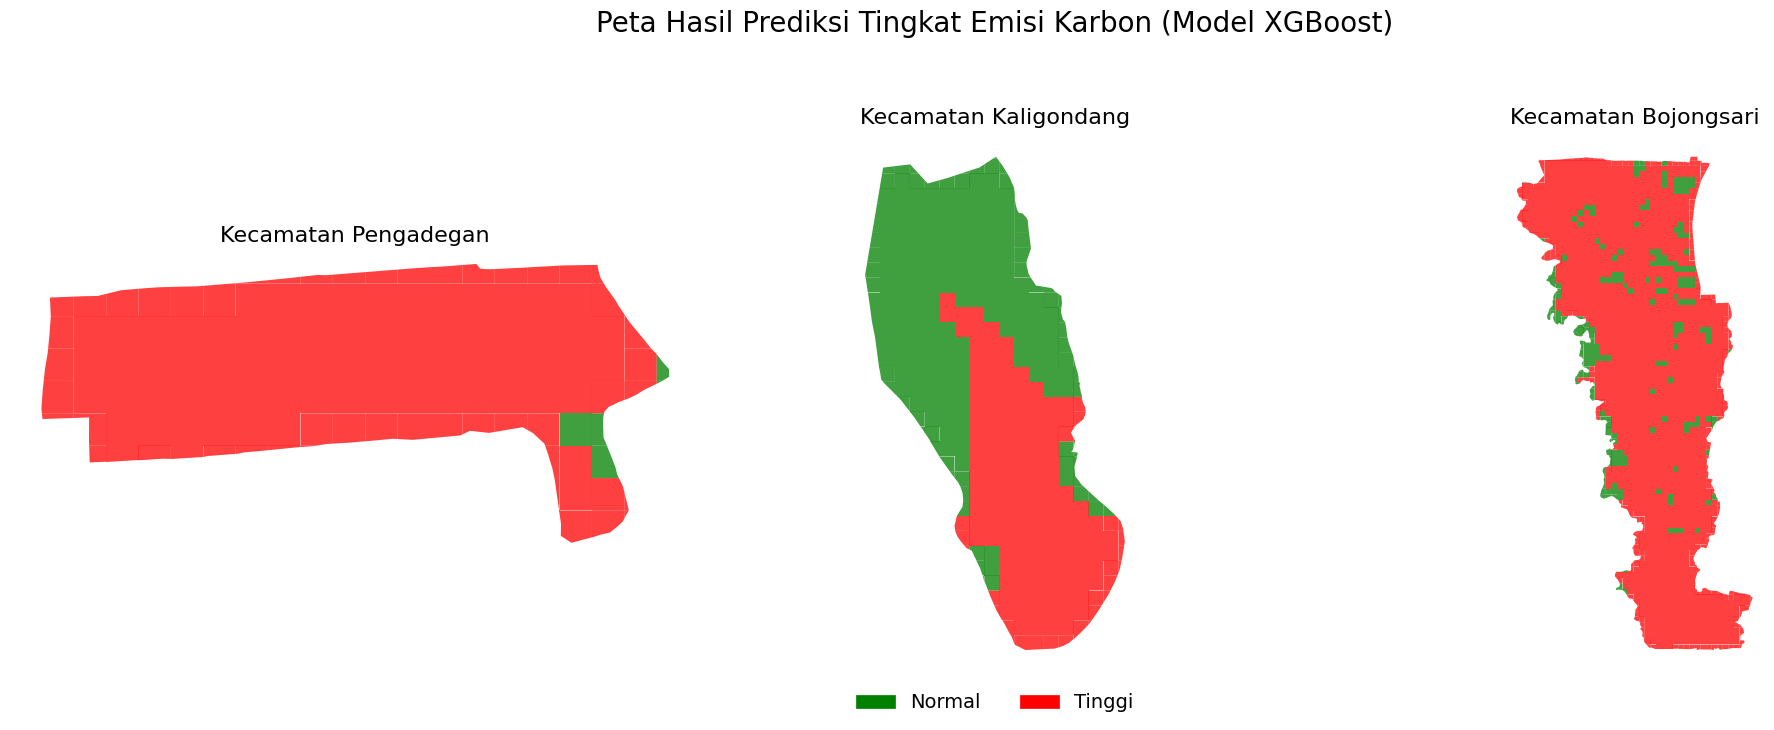

In [130]:
df_semua_grid['prediksi_xgb'] = encoder.inverse_transform(model_xgb.predict(df_semua_grid[FITUR]))

gdf_plot = df_semua_grid.to_crs(epsg=3857)
warna = {'Normal': 'green', 'Tinggi': 'red'}

fig, axes = plt.subplots(1, 3, figsize=(20, 8), subplot_kw={'aspect': 'equal'})
fig.suptitle("Peta Hasil Prediksi Tingkat Emisi Karbon (Model XGBoost)", fontsize=20, y=0.95)

for i, kec_full in enumerate(KECAMATAN_TERPILIH):
    kec_name = kec_full.split(",")[0]
    ax = axes[i]

    kec_data = gdf_plot[gdf_plot['kecamatan'] == kec_name]

    if not kec_data.empty:
        kec_data.plot(
            ax=ax,
            color=kec_data['prediksi_xgb'].map(warna),
            alpha=0.75
        )

    ax.set_title(f'Kecamatan {kec_name}', fontsize=16)
    ax.axis('off')

legend_handles = [plt.Rectangle((0,0),1,1, color=v, label=k) for k,v in warna.items()]
plt.figlegend(handles=legend_handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.05), fontsize=14, frameon=False)
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.show()

### **6.2. Interpretasi Hasil per Kecamatan**

Menganalisis hasil prediksi secara kuantitatif untuk memberikan rekomendasi atau kesimpulan spesifik bagi setiap kecamatan.

In [131]:
interpretasi_data = []

for kec_full in KECAMATAN_TERPILIH:
    kec_name = kec_full.split(",")[0]
    kec_data = df_semua_grid[df_semua_grid['kecamatan'] == kec_name]

    if kec_data.empty: continue

    persen_normal = (kec_data['prediksi_xgb'] == 'Normal').mean() * 100

    if persen_normal > 60:
        keterangan = "Kondisi cenderung baik. Mayoritas area memiliki RTH cukup dan kepadatan terkendali."
    elif 40 <= persen_normal <= 60:
        keterangan = "Kondisi campuran. Terdapat keseimbangan antara area padat dan area hijau."
    else:
        keterangan = "Perlu perhatian. Mayoritas area padat, RTH terbatas, berpotensi emisi tinggi."

    stats = kec_data.agg({
        'persentase_hijau': 'mean',
        'kepadatan_jalan': 'mean',
        'kepadatan_bangunan': 'mean'
    })

    interpretasi_data.append({
        'Kecamatan': kec_name,
        'Prediksi Area "Normal" (%)': f"{persen_normal:.2f}%",
        'Rata-rata % Hijau': f"{stats['persentase_hijau']:.2f}%",
        'Rata-rata Kepadatan Jalan': f"{stats['kepadatan_jalan']:.2f}",
        'Rata-rata Kepadatan Bangunan': f"{stats['kepadatan_bangunan']:.2f}",
        'Interpretasi': keterangan
    })

df_interpretasi = pd.DataFrame(interpretasi_data)

print("Tabel Interpretasi Hasil Prediksi per Kecamatan")
display(df_interpretasi.style.set_caption("Ringkasan Analisis dan Interpretasi Hasil Prediksi"))

Tabel Interpretasi Hasil Prediksi per Kecamatan


,Kecamatan,"Prediksi Area ""Normal"" (%)",Rata-rata % Hijau,Rata-rata Kepadatan Jalan,Rata-rata Kepadatan Bangunan,Interpretasi
0,Pengadegan,3.91%,82.05%,30.58,5057.01,"Perlu perhatian. Mayoritas area padat, RTH terbatas, berpotensi emisi tinggi."
1,Kaligondang,57.52%,15598263.27%,16.48,103.48,Kondisi campuran. Terdapat keseimbangan antara area padat dan area hijau.
2,Bojongsari,11.19%,6104.17%,71.76,1670.94,"Perlu perhatian. Mayoritas area padat, RTH terbatas, berpotensi emisi tinggi."


### **7. Simpan Hasil Akhir**

Sebagai langkah terakhir, semua hasil analisis, termasuk fitur yang diekstrak dan label prediksi, disimpan ke dalam sebuah file CSV untuk dokumentasi atau analisis lebih lanjut.

In [132]:
kolom_output = [
    'kecamatan', 'grid_id', 'kepadatan_jalan', 'kepadatan_bangunan',
    'persentase_hijau', 'label_emisi', 'prediksi_xgb', 'geometry'
]

df_output = pd.DataFrame(df_semua_grid[kolom_output])

nama_file_output = "hasil_prediksi_emisi_purbalingga.csv"
df_output.to_csv(nama_file_output, index=False)

print(f"\n[SUKSES] Semua proses telah selesai!")
print(f"Hasil akhir berhasil disimpan dalam file: '{nama_file_output}'")


[SUKSES] Semua proses telah selesai!
Hasil akhir berhasil disimpan dalam file: 'hasil_prediksi_emisi_purbalingga.csv'
